***Warning: Please do not use AI assistant (such as Gemini ♊ )for the Q&A in this exercise! Try solving them by yourself first!!) ***

---



In [ ]:
# Connect to your Google Drive (~20s)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Point to the folder containing the data in your Google Drive
folder = '/content/drive/MyDrive/2025_CAS_RPM_NN_GenAI_WS'

In [ ]:
!rm -rf '/content/Insurance-Fraud-Detection'

In [ ]:
# Unzip the folder
# Data from https://www.kaggle.com/datasets/pacificrm/car-insurance-fraud-detection?resource=download
!unzip $folder/car_insurance_fraud.zip

Streaming output truncated to the last 5000 lines.
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/100.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1002.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1005.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1006.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1007.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1008.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1009.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1010.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1011.jpg  
  inflating: Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1012.jpg  
  inflating: Insurance-Fraud-D

# Get the Required Packages Ready

In [ ]:
%%capture
# Install Packages
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install torch
!pip install torcheval
!pip install OpenCV

In [ ]:
# Import the packages used for this exercise
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryConfusionMatrix
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, WeightedRandomSampler

# Read in Data for this exercise

In [ ]:
# Point to the unzip folder containing the images

folder = '/content/Insurance-Fraud-Detection/Insurance-Fraud-Detection/'

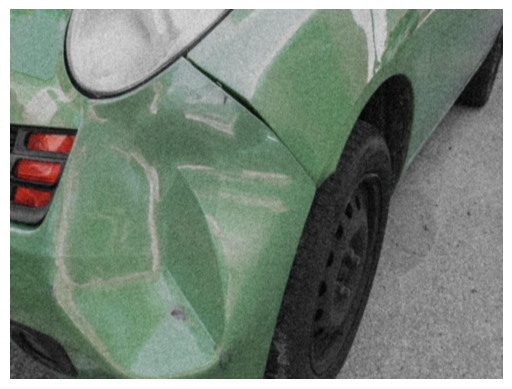

In [ ]:
# Let's look at some fraud images

# Load the image
image_path = folder + "train/Fraud/18.jpg"  # Change this to your image path
image1 = cv2.imread(image_path)

# Convert BGR to RGB (OpenCV loads images in BGR format)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image1)
plt.axis("off")  # Hide axes
plt.show()

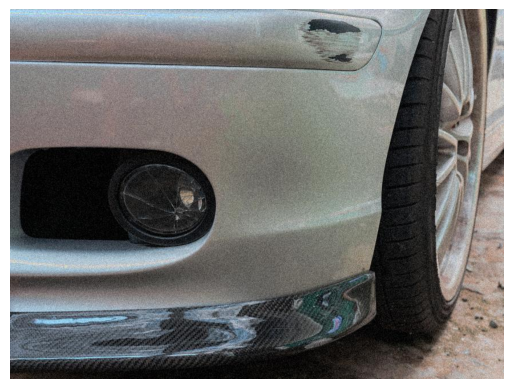

In [ ]:
# let's look at some non-fraud images

# Load the image
image_path = folder + "train/Non-Fraud/1.jpg"  # Change this to your image path
image2 = cv2.imread(image_path)

# Convert BGR to RGB (OpenCV loads images in BGR format)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image2)
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
# Let's look at the shape of the raw data

print(image1.shape) # (Length, Width, channels)
print(image2.shape) # it looks like the length and width can vary

(849, 1132, 3)
(649, 866, 3)


**Question**: What does the 3 mean in the output of the cell above? (Hint: Colors)

**Answer**: 3 signifies that the images are colored images (the "channels" are like RGB)


**Question:** Change the images in the cells above by changing the `image_path` variables. Do you notice anything in particular? (Not looking for anything in particular just write down any observations you have, for example the image sizes change across samples)

**Answer**: Color consistency, image size and contents are different (e.g., the angles).

**Question**: Our models typically expect the input to have a static shape. Given that our images our of different dimensions what do we need to do to satisfy this assumption?

**Answer**: We need to resize our images to a consistent, fixed size before feeding them into the model. This ensures that all input images have the same shape, satisfying the model's requirement.



In [ ]:
# Check % of fraudulent claims (one row is one claim for simplicity)

train_fraud_cnt = len([f for f in os.listdir(folder + "train/Fraud") if os.path.isfile(os.path.join(folder + "train/Fraud", f))])
train_non_fraud_cnt = len([f for f in os.listdir(folder + "train/Non-Fraud") if os.path.isfile(os.path.join(folder + "train/Non-Fraud", f))])

test_fraud_cnt = len([f for f in os.listdir(folder + "test/Fraud") if os.path.isfile(os.path.join(folder + "test/Fraud", f))])
test_non_fraud_cnt = len([f for f in os.listdir(folder + "test/Non-Fraud") if os.path.isfile(os.path.join(folder + "test/Non-Fraud", f))])

train_fraud_percentage = (train_fraud_cnt / (train_fraud_cnt + train_non_fraud_cnt)) * 100
test_fraud_percentage = (test_fraud_cnt / (test_fraud_cnt + test_non_fraud_cnt)) * 100

print(f"Number of fraudulent claims in train set: {train_fraud_cnt}")
print(f"Number of non-fraudulent claims in train set: {train_non_fraud_cnt}")

print(f"Number of fraudulent claims in test set: {test_fraud_cnt}")
print(f"Number of non-fraudulent claims in test set: {test_non_fraud_cnt}")


print(f"Percentage of fraud cases in train set: {train_fraud_percentage:.2f}%")
print(f"Percentage of fraud cases in test set: {test_fraud_percentage:.2f}%")



Number of fraudulent claims in train set: 200
Number of non-fraudulent claims in train set: 5000
Number of fraudulent claims in test set: 93
Number of non-fraudulent claims in test set: 1323
Percentage of fraud cases in train set: 3.85%
Percentage of fraud cases in test set: 6.57%


**Question**: Does our dataset have a class imbalance (i.e. very little fradulent claims)? If so, what potential issue it may bring without adjustment?

**Answer**: Yes, the percentage of fraud cases in both train and test sets are significantly lower than the percentage of non-fraud cases.

The main problem is that the model might become biased towards the majority class (e.g., using acuracy as the evaluation metric can be misleading). The model may overfit to the majority class and fail to generalize well to unseen data.

# Modeling

We will be doing CNN in this exercise

In [ ]:
# Parameters
# TO ADJUST AND PLAY BY YOURSELF!!!
num_filters = 32
kernel_size = 16
stride = 4
max_pool_size = 2
resize_image_height = 256
resize_image_width = 256
in_channels = 3 # 3 -> RGB, 1 -> Grayscale
batch_size = 32
num_epochs = 5

Define the Dataset and Dataloaders

In [ ]:
# Handle RGB and Grayscale differently
if in_channels == 1:
  transform = transforms.Compose([
      transforms.Resize((resize_image_height, resize_image_width)),  # need to resize to a standard dimension size
      transforms.Grayscale(num_output_channels=in_channels),
      transforms.ToTensor(),          # Convert images to tensor
  ])
else:
  transform = transforms.Compose([
      transforms.Resize((resize_image_height, resize_image_width)),  # need to resize to a standard dimension size
      transforms.ToTensor(),          # Convert images to tensor
  ])



In [ ]:
# Define dataset paths
train_dir = folder + "train"
test_dir = folder + "test"

In [ ]:
# class indices are currently determined alphabetically so 0 -> Fraud, 1 -> Non-Fraud
# Let's fix that with a transform

def correct_labels(label):
    return 1 if label == 0 else 0

In [ ]:
# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=correct_labels)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform, target_transform=correct_labels)

In [ ]:
# Print class labels
fraud_index = full_train_dataset.class_to_idx["Fraud"]
full_train_dataset.targets = [1 if label == fraud_index else 0 for label in full_train_dataset.targets]
print("Class Labels:", full_train_dataset.classes)

# Get original class-to-index mapping
full_train_dataset.class_to_idx = {
    "Non-Fraud": 0,
    "Fraud": 1
}
print("Class-to-Index Mapping:", full_train_dataset.class_to_idx)


Class Labels: ['Fraud', 'Non-Fraud']
Class-to-Index Mapping: {'Non-Fraud': 0, 'Fraud': 1}


In [ ]:
# Split into train & validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Count occurrences in train and validation sets (Use for training)
train_counts = Counter([full_train_dataset.targets[idx] for idx in train_dataset.indices])
val_counts = Counter([full_train_dataset.targets[idx] for idx in val_dataset.indices])

# Load and count test dataset (Unseen for testing)
test_dataset.targets = [1 if label == fraud_index else 0 for label in test_dataset.targets]
test_counts = Counter(test_dataset.targets)

print(f"Train set size: {len(train_dataset)}")
print(f"Train set distribution: {train_counts}")

print(f"Validation set size: {len(val_dataset)}")
print(f"Validation set distribution: {val_counts}")

print(f"Test set size: {len(test_dataset)}")
print(f"Test set distribution: {test_counts}")


Train set size: 4160
Train set distribution: Counter({0: 4005, 1: 155})
Validation set size: 1040
Validation set distribution: Counter({0: 995, 1: 45})
Test set size: 1416
Test set distribution: Counter({0: 1323, 1: 93})


In [ ]:
total_samples = len(train_dataset)

# Assign higher weight to fraud cases
weights = np.zeros(total_samples)
for idx, sample_idx in enumerate(train_dataset.indices):
    label = full_train_dataset.targets[sample_idx]
    weights[idx] = 1/train_counts[label]

# Create a WeightedRandomSampler for oversampling fraud cases
sampler = WeightedRandomSampler(weights, num_samples=total_samples, replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check a sample
images, labels = next(iter(train_loader))
print(f"Batch Image Shape: {images.shape}, Labels: {labels}")

Batch Image Shape: torch.Size([32, 3, 256, 256]), Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1])


**Question**: What's the first number in the Batch Image Shape mean?

**Answer**:It's the batch size we have defined earlier in the 'Parameters' cell.

**Question**: Above we used a weighted sampler to oversample the fraud cases. What other strategies could be used to help with the class imbalance?

**Answer**: The most popular approaches:
1) We can possibly undersample too - but since the data size is not big so it's not recommended as it may lead to information loss.
2) There's also another technical called 'SMOTE' (Synthetic Minority Over-sampling Technique). This create synthetic samples for the minority class by interpolating between existing minority class samples. This increases the number of minority class samples without simply duplicating them. 3) Data augmentation for the minority class to apply transformation (e.g., rotations, flips, noise addition) to existing minority class samples to create new, similar samples.

**Question**: Let's say we wanted to augment our data (apply rotations, flips, etc to create similar images and hopefully help the model generalize better). Where would we apply these transformations in the code above?

**Answer**: You would add the desired augmentation transformations to the transforms.Compose function above.

### Training a CNN




**Bonus Question**: Do I have to shuffle the validation data?

**Answer**: No, you do not have to shuffle the validation data. Since we are not updating the model between validation batches and are simply comparing predicitons results for each example in the validation set, the order we do the predictions on the validation data does not matter. Keeping the validation set consistent across epochs allows for a fair comparison of the model's performance across different training iterations, and it may introduce potential bias in model evaluation if the dataset is small





In [ ]:
#Training CNN Function
class CNNModel(nn.Module):
  """
  It consists of a convolutional layer, batch normalization, ReLU activation,
  max-pooling, flattening, a fully connected layer, and a sigmoid activation.

  Args:
        input_dims (int or tuple): The input image dimensions (height and width).
        in_channels (int): The number of input channels (e.g., 3 for RGB, 1 for grayscale).
        num_filters (int): The number of filters in the convolutional layer.
        kernel_size (int): The size (nxn) of the convolutional kernel.
        stride (int): The stride of the convolutional kernel.
  """


  def __init__(self, input_dims, in_channels, num_filters, kernel_size, stride):
    # Initializing the layers and components

    assert isinstance(input_dims, int) or isinstance(input_dims, tuple) or isinstance(input_dims, list), "input_dims must be an integer, tuple, or list"

    super(CNNModel, self).__init__()


    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=kernel_size, stride=stride)
    self.bn = nn.BatchNorm2d(num_filters)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=max_pool_size)
    self.flatten = nn.Flatten()

    # Dynamically compute linear layer size
    with torch.no_grad():
      if isinstance(input_dims, int):
        dummy_input = torch.randn(1, in_channels, input_dims, input_dims)
      else:
        dummy_input = torch.randn(1, in_channels, input_dims[0], input_dims[1])  # Correct input shape
        out = self.pool(self.relu(self.conv1(dummy_input)))  # Pass through layers
        linear_size = out.numel()  # Get flattened size

    self.fc = nn.Linear(linear_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

**Question**: Assume we have a 256 x 256 image with 1 channel (gray scale), and a convolutional filter with a 16x16 kernel, a stride of 3, and no padding. Can you draw an image and describe what this means?

**Answer**: Imagine a large grid (256x256) representing your input image. Now, picture a smaller 16x16 square (the kernel) placed on top of the image. The kernel moves across the image, stepping 3 pixels at a time, and calculates a new value for each step.

**Bonus Question:** What is the output shape of this single filter when convolved against the image?

**Answer:** 81 x 81

**Question**: Let's say we have the following:
- 5 x 5 grids
- 3 x 3 kernel
- stride = 1
- 2 x 2 max pooling window operation

Can you draw the process until the max pooling on the notepad? How big is the receptive field for a single element in the output of the max-pooling operation?

**Answer**: 4 x 4 receptive field of the original input grid

In [ ]:
# Create an instance of the model
model = CNNModel([resize_image_height, resize_image_width], in_channels, num_filters, kernel_size, stride)
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(16, 16), stride=(4, 4))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=28800, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

**Question**: How is the Adam optimizer different from vanilla stochastic gradient descent? (Hint: Adam stands for Adaptive Moment Estimation and this has something to do with Learning Rate)

**Answer**: On Adam optimizer, the learning rate for each parameter is adjusted individually based on past gradients.

**Bonus Question**: What is the Binary Cross-Entropy Loss and why do we use it instead of Mean Squared Error?

**Answer**: Binary Cross-Entropy Loss is a loss function commonly used for binary classification problems. It measures the difference between the predicted probability distribution and the true probability distribution for a binary outcome (e.g., 0 or 1).
It provides a probabilistic interpretation, better gradient behavior, and is naturally compatible with sigmoid activation.


CNN Training loop

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device
model.to(device)

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()

    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data).squeeze(1)
        loss = loss_fn(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss_history.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    recall = BinaryRecall()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data).squeeze(1)
            val_loss += loss_fn(output, target).item()
            pred = torch.round(output)
            correct += pred.eq(target.view_as(pred)).sum().item()
            recall.update(pred.int(), target.int())
    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)
    accuracy = 100. * correct / len(val_loader.dataset)
    recall_score = recall.compute()
    recall.reset()
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%, Recall: {recall_score:.2f}')

Using device: cuda
Epoch 1/5, Train Loss: 0.3718, Val Loss: 0.0151, Accuracy: 80.00%, Recall: 0.62
Epoch 2/5, Train Loss: 0.1204, Val Loss: 0.0083, Accuracy: 93.08%, Recall: 0.42
Epoch 3/5, Train Loss: 0.0895, Val Loss: 0.0063, Accuracy: 95.19%, Recall: 0.42
Epoch 4/5, Train Loss: 0.1114, Val Loss: 0.0071, Accuracy: 94.04%, Recall: 0.42
Epoch 5/5, Train Loss: 0.0615, Val Loss: 0.0082, Accuracy: 92.21%, Recall: 0.49


**Question**: Which line of code does the forward pass?

**Answer**: The forward pass is performed within the forward method of the CNNModel class

**Question**: Which line(s) of code calculate and do one iteration of back propagation?

**Answer**:
- loss.backward() (this step initialize the process)
- optimizer.step() (this step updates the parameters)

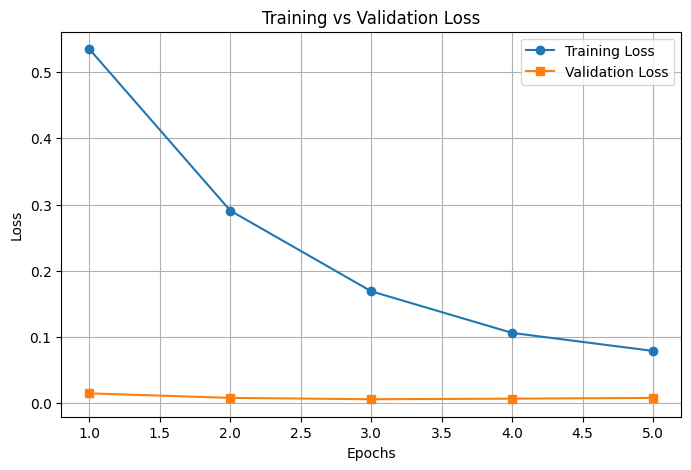

In [ ]:
x_axis = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(8, 5))
plt.plot(x_axis, train_loss_history, label="Training Loss", marker="o")
plt.plot(x_axis, val_loss_history, label="Validation Loss", marker="s")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



**Question**: What are the potential issues here?

**Answer**: The plot shows that the training loss is decreasing, which is good. However, the validation loss is fluctuating and not decreasing consistently.




**Question**: Is this the best combination of the hyperparameters selection? What can we do?

**Answer**: No. We can try random search or grid search, etc.


⏩ ***Team collaboration exercise:***
Let's mimic the 'parallel computation' on 'grid search', we will try the following hyperparameter combinations:
- kernel_size = [8, 16, 24]
- stride = [3, 4]
- max_pool_size = [2, 3]

therefore we have (kernal_size, stride, max_pool_size):
- 8, 3, 2
- 8, 3, 3
- 8, 4, 2
- 8, 4, 3
- 16, 3, 2
- 16, 3, 3
- 16, 4, 2
- 16, 4, 3
- 24, 3, 2
- 24, 3, 3
- 24, 4, 2
- 24, 4, 3

let's run separately (but at the same time) and cosolidate results!  

# Validate on Unseen Data

Accuracy: 89.48%
Precision: 27.42%
Recall: 36.56%
F1 Score: 31.34%
Confusion Matrix:


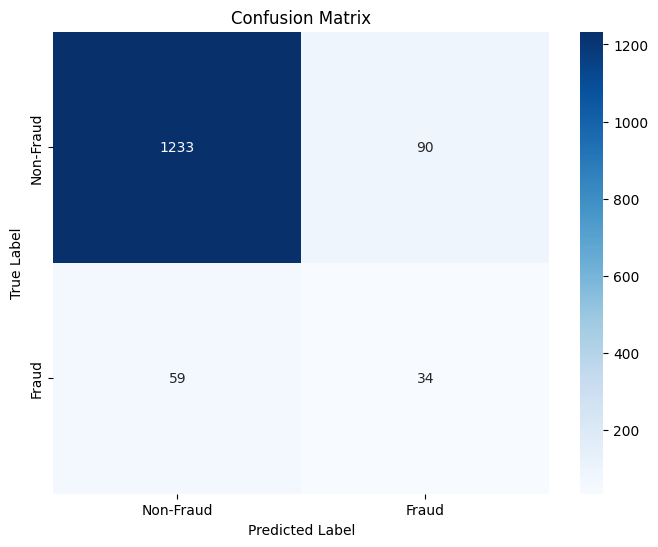

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize metrics
accuracy_metric = BinaryAccuracy().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)
f1_metric = BinaryF1Score().to(device)
conf_matrix_metric = BinaryConfusionMatrix().to(device)

correct = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.int().to(device)

        # Forward pass
        output = model(data).squeeze(1)


        # Convert probabilities to binary predictions (threshold at 0.5)
        pred = torch.round(output).int()
        # Store predictions & targets for confusion matrix
        all_preds.append(pred)
        all_targets.append(target)

        # Update metrics
        accuracy_metric.update(pred, target)
        precision_metric.update(pred, target)
        recall_metric.update(pred, target)
        f1_metric.update(pred, target)
        conf_matrix_metric.update(pred, target)

# Compute final metric scores
accuracy = accuracy_metric.compute()
precision = precision_metric.compute()
recall = recall_metric.compute()
f1_score = f1_metric.compute()
conf_matrix = conf_matrix_metric.compute()

# Reset metrics for next evaluation
accuracy_metric.reset()
precision_metric.reset()
recall_metric.reset()
f1_metric.reset()
conf_matrix_metric.reset()

# Print results and plot confusion matrix
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")
print("Confusion Matrix:")

conf_matrix = conf_matrix.cpu().numpy()  # Move to CPU and convert to NumPy array
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix.astype(int), annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.class_to_idx, yticklabels=full_train_dataset.class_to_idx)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Question**: How many False Positives, False Negatives, True Positives, and True Negatives did our model predict?

**Answer**:
1323 non-fraud in test and 93 fraud in test
- TP: The number of fraudulent claims correctly predicted as fraudulent - 34
- TN: The number of non-fraudulent claims correctly predicted as non-fraudulent - 1233
- FP: The number of non-fraudulent claims incorrectly predicted as fraudulent - 90
- FN: The number of fraudulent claims incorrectly predicted as non-fraudulent - 59

**Question**: Is accuracy a suitable metric for us to evaluate the performance of our model? Why/Why not? If not what metric(s) are better and why?

**Answer**:In imbalanced datasets, accuracy can be misleading because a model can achieve high accuracy by simply predicting the majority class most of the time. For example, if 95% of claims are non-fraudulent, a model that always predicts "non-fraudulent" would have 95% accuracy, even without identifying any fraudulent claims. In addition, in fraud detection, the primary goal is to identify fraudulent claims accurately, even if it means misclassifying some non-fraudulent claims. Accuracy alone doesn't capture this objective. For example, f1-score and recall (proportion of correctly predicted fradulent claims out of all actual fraudulent claims) can be better metrics.

**Question**: What architectural changes would you make to the CNN above (ie more hidden layers, different activation functions, more filters, more convolutional layers)?

**Answer**:
Yes:
- more hidden layers
- more filters (allows the model to learn a richer set of features from the input)
- more convolutional layers (enhance the model's ability to extract hierarchical features and learn complex patterns)
- add regularization such as dropout and L1/L2 regularization (already had batch normalization in)